# Imports

In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits, ascii
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/radam/Desktop/PITSZItestSBI/'

In [3]:
#----- Physical model parameters
# Global
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 30*u.arcsec, -10*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

# Fluctuations
fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_statistics = 'gaussian'
fluct_seed = None

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 15*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1/beam_FWHM.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov = 1/(7*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_seed = None

In [5]:
#----- Analysis parameters
# Pk measurement
Nbins_pk = 10
scale_bins = 'log'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(2*beam_FWHM.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

method_setup_overwrite = False

# SBI parameters

# Data simulation

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':fluct_statistics,
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}
if fluct_seed is not None: mock.model_seed_fluctuation = fluct_seed

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [6, 5]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = 50*u.kpc
mock.los_size  = 2*u.Mpc
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 59 , 41
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   1855.0   ] kpc ; [   6.083    ,   4.917    ] arcmin
   L.o.S. resolution :         50.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.003067  /  0.061349   1/arcsec
   k min/max L.o.S. :          0.000488  /  0.009756   1/kpc
   k max Nyquist :             0.061349   1/arcsec
   k max Nyquist :             0.009756   1/kpc


In [7]:
#===== Initiate a data object and fake data
#----- Init with the mock
data = pitszi.Data(mock.get_sz_map(), mock.get_map_header())
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model = [noise_r, noise_k]

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
data.mask = mask

#----- Define the noise properties
data.noise_mc = data.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.get_map_center())
data.noise_rms = data.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)
if os.path.exists(data.output_dir+'/data_image_noise_covariance_matrix.pkl'):
    data.load_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')
else:
    data.noise_covmat = data.get_noise_covariance_from_model(Nmc=1000)
    data.save_noise_covariance(data.output_dir+'/data_image_noise_covariance_matrix.pkl')

#----- Mock the data
img = data.set_image_to_mock(mock, model_no_fluctuations=False, 
                             noise_origin='model', noise_center=mock.get_map_center(), noise_seed=noise_seed)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                           Data                             
------------------------------------------------------------


/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_7314/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_7314/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1
/var/folders/vn/s8_3jv496gz7jpw5mh082r8r0000gn/T/ipykernel_7314/3583775950.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  noise_k = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)*1e-1


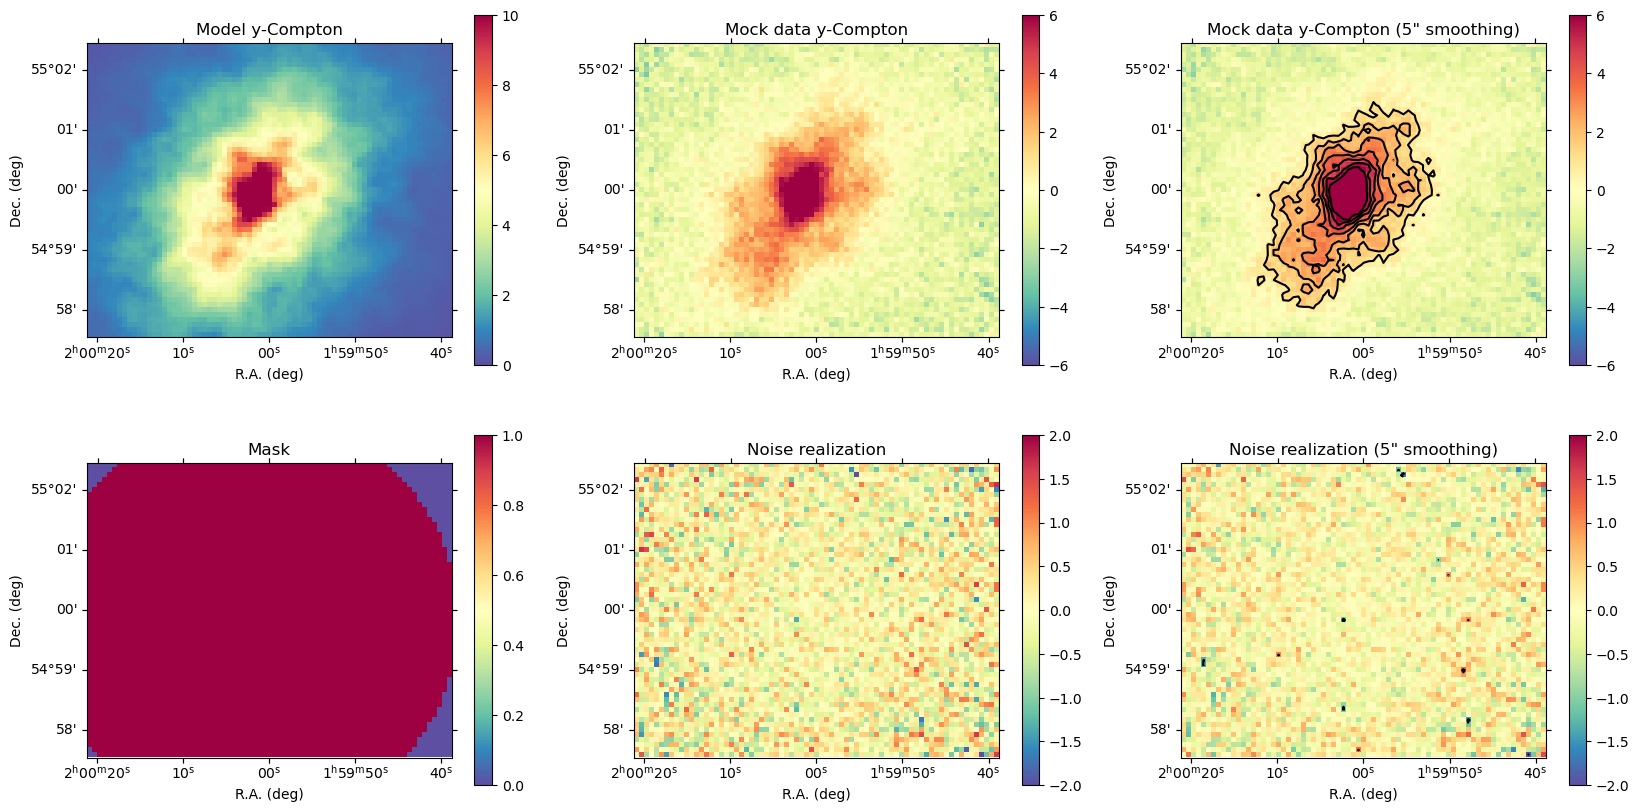

In [8]:
visu_smooth = 5

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(20, 10))

ax = plt.subplot(2, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.image, sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data.header))
plt.imshow(data.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data.header))
plt.imshow(data.noise_mc[0]*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
plt.title('Noise realization')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data.header))
plt.imshow(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-2, vmax=2)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data.noise_mc[0], sigma=visu_smooth/2.35/data.header['CDELT2']/3600)/rms, levels=[-3,3], colors='k')
plt.title('Noise realization ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# CIB data augmentation devs

In [9]:
def simu_cib(header, beam_FWHM, TF, Nsim=1000, Scut_high=100, Scut_low=0.0):
    y2mjy = -12e3
    sigma2fwhm = 2*np.sqrt(2*np.log(2))

    RA0, Dec0 = header['CRVAL1'], header['CRVAL2']
    ramap, decmap = map_tools.get_radec_map(header)
    src = np.zeros((Nsim, header['NAXIS2'], header['NAXIS1']))
    
    path     = '/Users/radam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/sides-public-release-main/cats/CIB_cat_sim/'
    ignored  = {".DS_Store"}
    catfiles = [x for x in os.listdir(path) if x not in ignored]
    np.random.shuffle(catfiles)
    
    for imc in range(Nsim):
        if Nsim>1 and imc % 10 == 0: print(imc, '/', Nsim)
        hdul = fits.open(path+catfiles[imc])
        cat_imc = hdul[1].data
        hdul.close()
        w1 = cat_imc['SNIKA2000']*1e3 > Scut_low
        w2 = cat_imc['SNIKA2000']*1e3 < Scut_high
        cat_imc = cat_imc[w1*w2]
        
        src_imc = np.zeros((header['NAXIS2'], header['NAXIS1']))
        for isrc in range(len(cat_imc)):
            dist_map = map_tools.greatcircle(ramap, decmap, RA0+cat_imc['ra'][isrc], Dec0+cat_imc['dec'][isrc])
            flux = cat_imc['SNIKA2000'][isrc]*1e3
            src_imc += flux*np.exp(-dist_map**2/2/(beam_FWHM.to_value('deg')/sigma2fwhm)**2)
                
        img_conv = pitszi.utils_pk.apply_transfer_function(src_imc, header['CDELT2']*3600, beam_FWHM.to_value('arcsec'), TF)
        src[imc,:,:] = img_conv
                
    return src/y2mjy

In [10]:
cib_mc = simu_cib(data.header, beam_FWHM, TF, Nsim=100, Scut_high=100, Scut_low=0.001)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [11]:
model = copy.deepcopy(mock)

In [12]:
cl_Finfer = pitszi.InferenceFluctuation(data, model,
                                        nuisance_bkg_mc1=cib_mc,
                                        method_use_covmat=False, silent=False,
                                        output_dir=output_dir)

#----- Define binning
cl_Finfer.kbin_min   = kmin_pk
cl_Finfer.kbin_max   = kmax_pk
cl_Finfer.kbin_Nbin  = Nbins_pk
cl_Finfer.kbin_scale = scale_bins

#----- Weight definition
RA0, Dec0 = data.header['CRVAL1'], data.header['CRVAL2']
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, RA0, Dec0)*60
roi = dist_map*0
roi[dist_map < 3] = 1
cl_Finfer.set_method_w8(roi_mask=roi,
                        apply_radial_model=method_w8_radial, 
                        conv_radial_model_beam=method_w8_beam, 
                        conv_radial_model_TF=method_w8_TF, 
                        remove_GNFW_core=True,
                        smooth_FWHM=method_w8_smooth)
    
#----- Setup
#cl_Finfer.pk_setup(Nmc=100)
cl_Finfer.get_kbin_counts()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.


array([  2.,   4.,   6.,   8.,  14.,  22.,  30.,  58.,  90., 138.])

In [13]:
kpc2arcsec = ((1*u.kpc/cl_Finfer.model.D_ang).to_value('')*u.rad).to_value('arcsec')

kedges = cl_Finfer.get_kedges().to_value('arcsec-1')*kpc2arcsec**1
reso   = cl_Finfer.model.get_map_reso().to_value('arcsec')*kpc2arcsec**-1
model_ymap = cl_Finfer.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=cl_Finfer.data1.psf_fwhm)

cib_pk2d = np.zeros((len(cib_mc), len(kedges)-1))
for icib in range(len(cib_mc)):
    dy_image = cib_mc[icib]/ model_ymap * cl_Finfer.method_w8
    dy_image[model_ymap <=0] = 0
    k2d, cib_pk2d_i = pitszi.utils_pk.extract_pk2d(dy_image, reso, kedges=kedges)
    cib_pk2d[icib,:] = cib_pk2d_i

In [14]:
dlnc = pitszi.utils_pk.pk_data_augmentation(k2d, cib_pk2d, Nsim=1000, method='LogNormCov')
dnni = pitszi.utils_pk.pk_data_augmentation(k2d, cib_pk2d, Nsim=1000, method='NearNeighborsItpl', n_nearest=99)

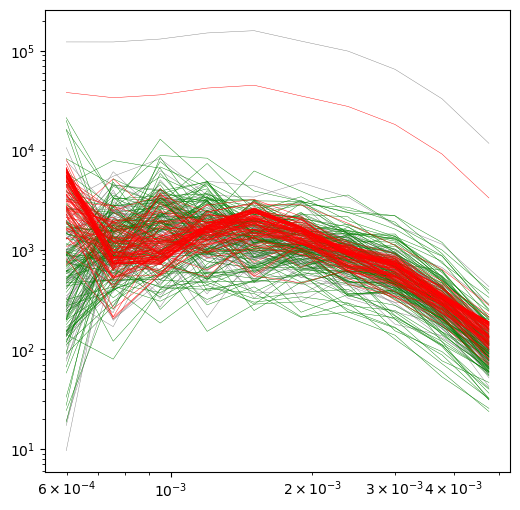

In [16]:
plt.figure(figsize=(6,6))
plt.errorbar(cl_Finfer._kctr_kpc, cl_Finfer._pk2d_bkg, cl_Finfer._pk2d_bkg_rms, color='k')
for i in range(100): plt.loglog(k2d, cib_pk2d[i], color='grey', lw=0.3)
for i in range(100): plt.loglog(k2d, dlnc[i], color='green', lw=0.3)
for i in range(100): plt.loglog(k2d, dnni[i], color='r', lw=0.3)
plt.xscale('log')
plt.yscale('log')

# SBI simulator

In [ ]:
def simulator_pk2d(parameters):

    #========== Modify the cluster model
    cl_Finfer.model.model_seed_fluctuation = np.random.randint(0, 2**32 - 1)
    cl_Finfer.model.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                  'statistics': 'gaussian',
                                                  'Norm': parameters[0],
                                                  'slope': -11/3,
                                                  'Linj': parameters[1]*u.kpc,
                                                  'Ldis': 1*u.kpc}
    
    #========== Extract the new pk2d
    cl_Finfer.nuisance_Anoise = 0
    cl_Finfer.nuisance_Abkg   = 0
    k2d, pk2d_sz = cl_Finfer.get_pk2d_model_brute()
    
    #========== add noise and CIB
    CIB   = pitszi.utils_pk.pk_data_augmentation(k2d, cib_pk2d,   Nsim=1, method='LogNormCov')[0]
    noise = pitszi.utils_pk.pk_data_augmentation(k2d, noise_pk2d, Nsim=1, method='LogNormCov')[0]
    pk2d = pk2d_sz + noise + CIB
    
    # === Security patch to get ride of NaN and Inf
    if not np.all(np.isfinite(pk2d)):
        print(f"[Warning] simulator: NaN or Inf detected for parameters={parameters}. Correction applied.")
        pk2d = np.nan_to_num(pk2d, nan=0.0, posinf=0.0, neginf=0.0)
    
    return pk2d



In [28]:
pitszi.utils_pk.pk_data_augmentation(k2d, cib_pk2d, Nsim=1, method='LogNormCov')[0]

array([ 331.89574369, 1207.84956514, 1631.29080721, 1194.04462896,
       1161.82939412, 1340.83169757, 1314.4386802 ,  964.80675414,
        338.67772795,  201.62361501])